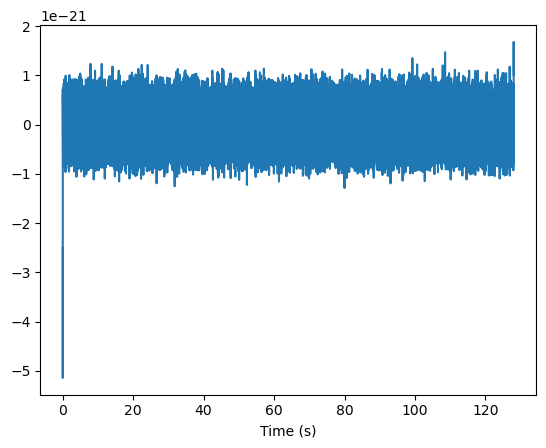

In [3]:
from pycbc.waveform import get_td_waveform
import numpy as np
import matplotlib.pyplot as plt
from pycbc.filter import matched_filter
# As an example we use the GW150914 data
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.frame import read_frame


strain=read_frame("PyCBC_T2_4.gwf","H1:TEST-STRAIN",0,128)

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)')
plt.show()

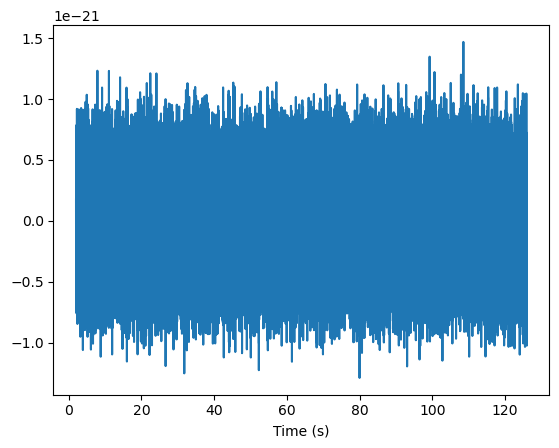

In [4]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

plt.plot(conditioned.sample_times, conditioned,)
plt.xlabel('Time (s)')
plt.show()

(30, 1024)

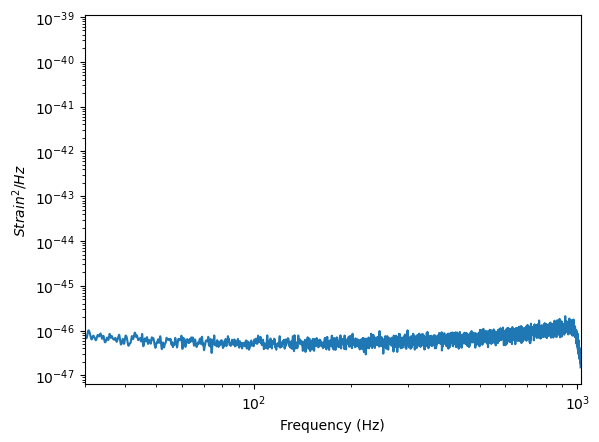

In [5]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(30, 1024)

For m=22 solar masses:


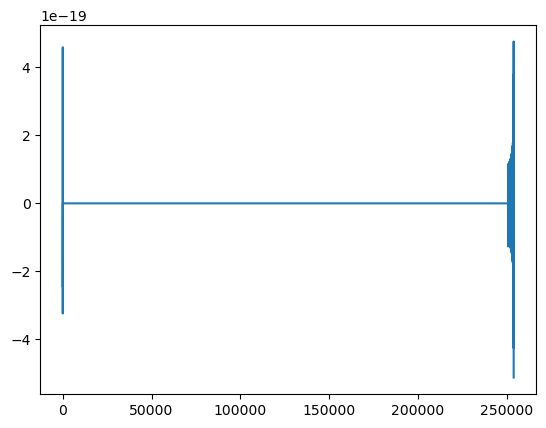

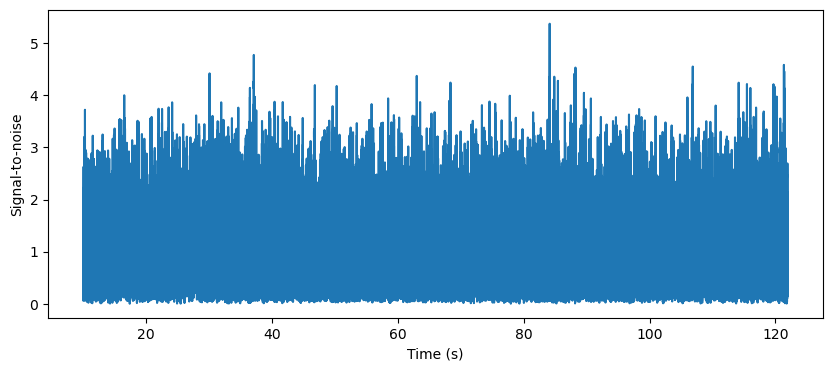

We found a signal at 84.1240234375s with SNR 5.369386717964736


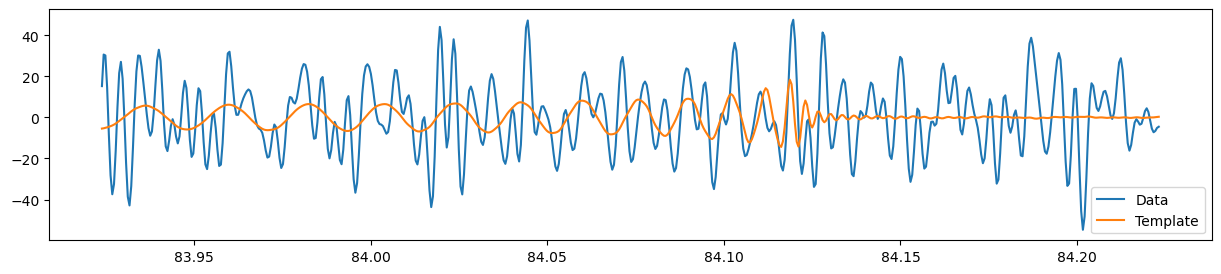

For m=36 solar masses:


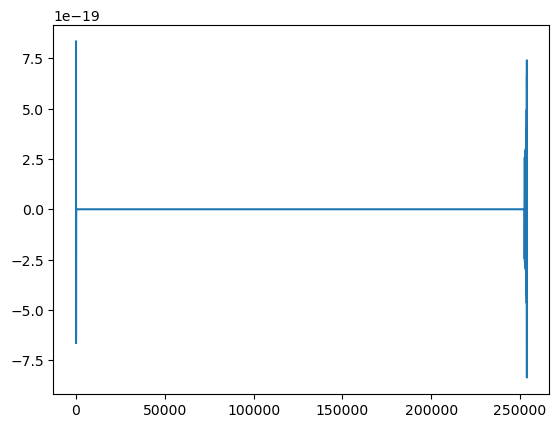

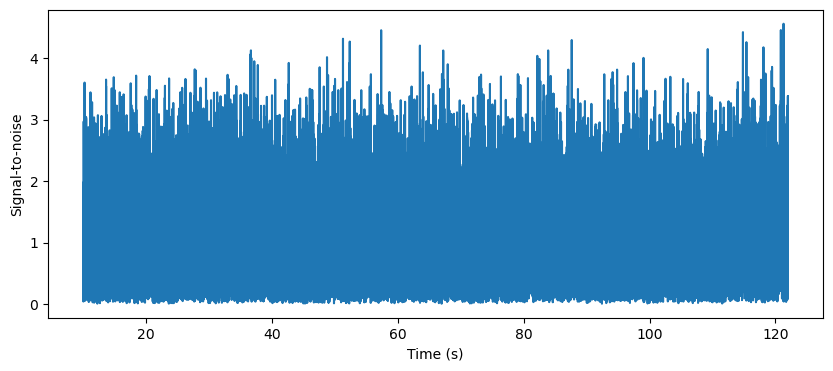

We found a signal at 121.3056640625s with SNR 4.560045889858683


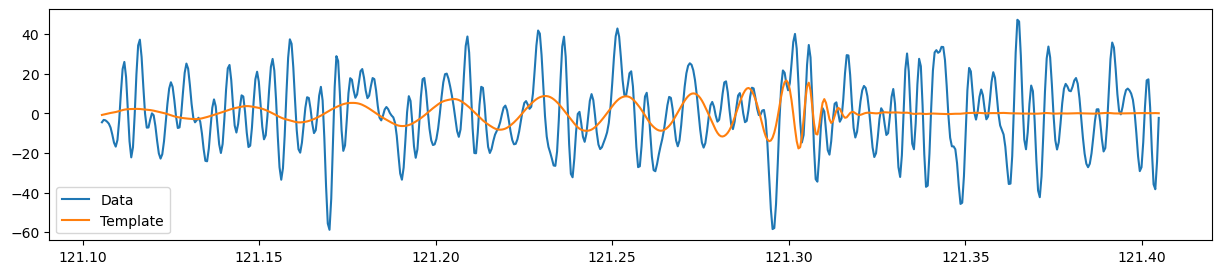

For m=50 solar masses:


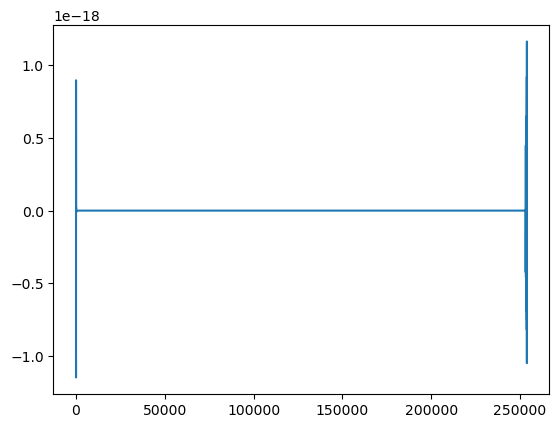

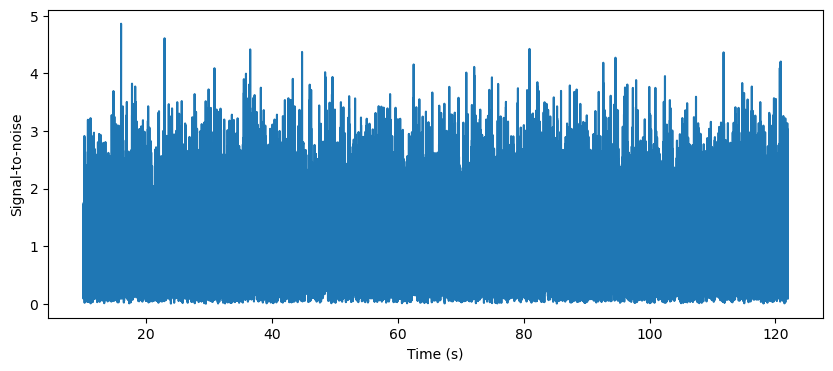

We found a signal at 15.9931640625s with SNR 4.8625411022168015


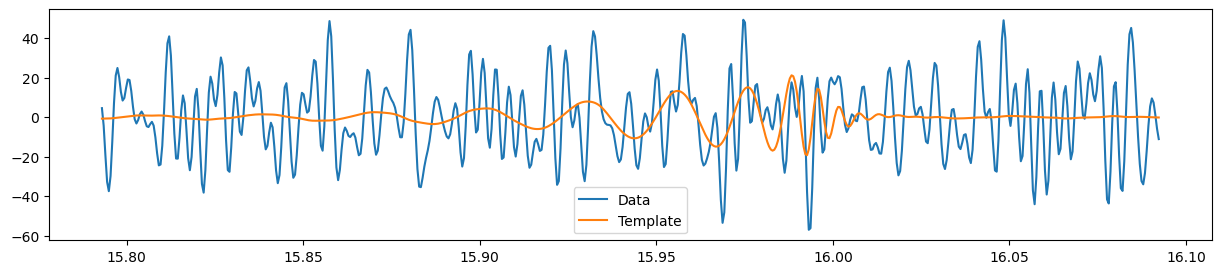

In [6]:
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, which is within the posterior probability
# of GW150914. 
#m = 36 # Solar masses
for m in [22,36,50]: 
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=conditioned.delta_t,
                         f_lower=20)
    
    # We will resize the vector to match our data
    hp.resize(len(conditioned))
    
    # The waveform begins at the start of the vector, so if we want the
    # SNR time series to correspond to the approximate merger location
    # we need to shift the data so that the merger is approximately at the 
    # first bin of the data.
    
    # This function rotates the vector by a fixed amount of time.
    # It treats the data as if it were on a ring. Note that
    # time stamps are *not* in general affected, but the true
    # position in the vector is.
    #
    # By convention waveforms returned from `get_td_waveform` have their
    # merger stamped with time zero, so we can use the start time to 
    # shift the merger into position
    print("For m={} solar masses:".format(m))
    template = hp.cyclic_time_shift(hp.start_time)
    plt.plot(template)
    plt.show()
    
    
    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=20)
    
    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr = snr.crop(4 + 4, 4)
    
    # Why am I taking an abs() here?
    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.
    plt.figure(figsize=[10, 4])
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('Signal-to-noise')
    plt.xlabel('Time (s)')
    plt.show()
    
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]
    
    print("We found a signal at {}s with SNR {}".format(time, 
                                                        abs(snrp)))



    
    from pycbc.filter import sigma
    
    # The time, amplitude, and phase of the SNR peak tell us how to align
    # our proposed signal with the data.
    
    # Shift the template to the peak time
    dt = time - conditioned.start_time
    aligned = template.cyclic_time_shift(dt)
    
    # scale the template so that it would have SNR 1 in this data
    aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
    
    # Scale the template amplitude and phase to the peak value
    aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
    aligned.start_time = conditioned.start_time
    
    
    # We do it this way so that we can whiten both the template and the data
    white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
    
    # apply a smoothing of the turnon of the template to avoid a transient
    # from the sharp turn on in the waveform.
    tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()
    
    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)
    
    # Select the time around the merger
    white_data = white_data.time_slice(time-.2, time+.1)
    white_template = white_template.time_slice(time-.2, time+.1)
    
    plt.figure(figsize=[15, 3])
    plt.plot(white_data.sample_times, white_data, label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")
    plt.legend()
    plt.show()
    '''
    subtracted = conditioned - aligned
    
    # Plot the original data and the subtracted signal data
    
    for data, title in [(conditioned, 'Original H1 Data'),
                        (subtracted, 'Signal Subtracted from H1 Data')]:
    
        t, f, p = data.whiten(4, 4).qtransform(.001,
                                                      logfsteps=100,
                                                      qrange=(8, 8),
                                                      frange=(20, 512))
        plt.figure(figsize=[15, 3])
        plt.title(title)
        plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
        plt.yscale('log')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.xlim(time - .7, time + .5)
        plt.show()'''